Building AI model to classify logs into P1, P2, P3 and P4.

### Data Loading and Exploration 

#### Efficient Data Loading
- ***Chunk Loading:*** Due to dataset size, data is loaded in chunks to prevent memory overflow.
- ***PySpark Integration:*** For scalability, Pyspark is utilized for parallel data processing.

Library imports

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from scipy.sparse import hstack

from sklearn.linear_model import SGDClassifier

from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

Configurations

In [2]:
%matplotlib inline
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/rshekar/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/rshekar/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

Loading dataset in chunks

In [3]:
chunk_size = 500000
chunks = pd.read_csv('../datasets/processed_logs.csv', chunksize=chunk_size)
logs_df = pd.concat(chunks, ignore_index=True)

/var/folders/hw/2qqt9k2547j0gf2k4f_hq0lc0000gn/T/ipykernel_69546/3486445007.py:3: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  logs_df = pd.concat(chunks, ignore_index=True)


In [4]:
print(logs_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8505002 entries, 0 to 8505001
Data columns (total 4 columns):
 #   Column     Dtype 
---  ------     ----- 
 0   timestamp  object
 1   level      object
 2   message    object
 3   source     object
dtypes: object(4)
memory usage: 259.6+ MB
None


#### Initial Data Inspection
- ***Schema:*** The dataset consists of timestamp, level, message and source columns.
- ***Null Values:*** Checked for missing or malformed entries.

In [5]:
print(logs_df.head())

print(logs_df.isnull().sum())

                  timestamp   level  \
0  Thu Jun 09 06:07:04 2005  notice   
1  Thu Jun 09 06:07:04 2005  notice   
2  Thu Jun 09 06:07:04 2005  notice   
3  Thu Jun 09 06:07:05 2005  notice   
4  Thu Jun 09 06:07:05 2005  notice   

                                             message  source  
0                 LDAP: Built with OpenLDAP LDAP SDK  Apache  
1                      LDAP: SSL support unavailable  Apache  
2  suEXEC mechanism enabled (wrapper: /usr/sbin/s...  Apache  
3  Digest: generating secret for digest authentic...  Apache  
4                                       Digest: done  Apache  
timestamp    2500000
level              0
message          101
source             0
dtype: int64


#### Exploratory Data Analysis (EDA) and Cleaning

In [6]:
print(logs_df['level'].value_counts())

level
INFO                                5954567
WARN                                 833297
ERROR                                625355
CRITICAL                             624647
FATAL                                321471
                                     ...   
GoogleSoftwareUpdateAgent[35089]          1
netbiosd[35901]                           1
netbiosd[31279]                           1
helpd[36107]                              1
GoogleSoftwareUpdateAgent[33940]          1
Name: count, Length: 1040, dtype: int64


The level column has 1,040 unique values, but standard log levels like INFO, WARN, ERROR, CRITICAL, and FATAL dominate the dataset. The remaining values appear to be process names or non-standard log levels, such as GoogleSoftwareUpdateAgent[35089], netbiosd[35901], etc.

Separating standard log levels and process names.

In [7]:
standard_levels = ['INFO', 'WARN', 'ERROR', 'CRITICAL', 'FATAL', 'DEBUG']

logs_df["cleaned_level"] = logs_df["level"].apply(lambda x: x.upper() if x.upper() in standard_levels else 'OTHER')

print(logs_df["cleaned_level"].value_counts())

cleaned_level
INFO        5954567
WARN         833465
ERROR        663436
CRITICAL     624647
FATAL        321471
OTHER        107416
Name: count, dtype: int64


Extracting log source (process names) if 'level' is not standard

In [8]:
logs_df["log_source"] = logs_df.apply(lambda row: row["level"] if row["cleaned_level"] == "OTHER" else "SYSTEM", axis=1)

print(logs_df["log_source"].value_counts())

log_source
SYSTEM                              8397586
kernel[0]                             41181
notice                                13755
kernel                                13670
QQ[10018]                              3202
                                     ...   
GoogleSoftwareUpdateAgent[36810]          1
systemstats[36717]                        1
mdworker[36690]                           1
mdworker[35812]                           1
netbiosd[34560]                           1
Name: count, Length: 1034, dtype: int64


#### Text Preprocessing (NLP)
- ***Lowercasing:*** Coverting all messages to lowercase.
- ***Punctuation Removal:*** Removed unnecessary punctuation.
- ***Stopword Removal:*** Eliminated common stopwords using NLTK.
- ***Lemmatization:*** Reduced words to their base forms for uniformity.

In [9]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Function to clean log messages
def preprocess_log_message(message):
    # Checking if the message is str object if not replacing NaN or non-string values with an empty string
    if not isinstance(message, str):
        message = ''

    message = message.lower()
    message = re.sub(r'[^a-zA-Z0-9\s]', '', message) # Remove punctuation
    words = message.split()

    if words:
        message = ' '.join([lemmatizer.lemmatize(word) for word in message.split() if word not in stop_words])
    return message

logs_df['cleaned_message'] = logs_df["message"].apply(preprocess_log_message)

In [10]:
logs_df["cleaned_message"].head(10)

0                         ldap built openldap ldap sdk
1                         ldap ssl support unavailable
2       suexec mechanism enabled wrapper usrsbinsuexec
3       digest generating secret digest authentication
4                                          digest done
5                         ldap built openldap ldap sdk
6                         ldap ssl support unavailable
7    envcreatebean2 factory error creating channelj...
8               configupdate cant create channeljnijni
9          envcreatebean2 factory error creating vm vm
Name: cleaned_message, dtype: object

#### Feature Engineering
- ***Message Length:*** Creating a feature based on the number of characters in each message.
- ***Word Count:*** Extracting the total number of words per log entry.
- ***TF-IDF Vectorization:*** Applying TF-IDF to covert text data into numerical format.
<!-- - ***Temporal Features:*** Extracting log timestamps -->
- ***Log Level Encoding:*** Converting levels to numerical values.

Log Message Length

In [11]:
logs_df["message_length"] = logs_df["message"].apply(lambda x: len(x) if isinstance(x, str) else 0)

Word Count

In [12]:
logs_df["word_count"] = logs_df['cleaned_message'].apply(lambda x: len(x.split()) if isinstance(x, str) else 0)

Special Character Frequency

In [13]:
logs_df['special_char_count'] = logs_df['message'].apply(lambda x: len(re.findall(r'[^a-zA-Z0-9\s]', str(x))) if isinstance(x, str) else 0)

TF-IDF Vectorization

In [14]:
vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = vectorizer.fit_transform(logs_df["cleaned_message"])

N-Grams to capture word combinations

In [15]:
vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=5000)
X_ngrams = vectorizer.fit_transform(logs_df["cleaned_message"])

Log Level Encoding

In [16]:
level_mapping = {'INFO': 4, 'WARN': 3, 'ERROR': 2, 'CRITICAL': 1, 'FATAL': 1, 'OTHER': 4}
logs_df["level_encoded"] = logs_df["cleaned_level"].map(level_mapping)
logs_df["level_encoded"].isna().sum()

0

In [17]:
logs_df["level_encoded"] = logs_df['level_encoded'].fillna(4)

In [18]:
def create_sequences(data, window_size=5):
    sequences = []
    for i in range(len(data) - window_size):
        sequence = data[i:i + window_size]
        sequences.append(sequence)
    return sequences

log_sequences = create_sequences(logs_df['cleaned_message'].tolist())

In [19]:
print(logs_df["message_length"].describe())

count    8.505002e+06
mean     6.027474e+01
std      3.888710e+01
min      0.000000e+00
25%      3.500000e+01
50%      4.900000e+01
75%      7.700000e+01
max      1.264000e+03
Name: message_length, dtype: float64


/var/folders/hw/2qqt9k2547j0gf2k4f_hq0lc0000gn/T/ipykernel_69546/3405839823.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=logs_df, x='cleaned_level', order=logs_df['cleaned_level'].value_counts().index, palette='Set2')


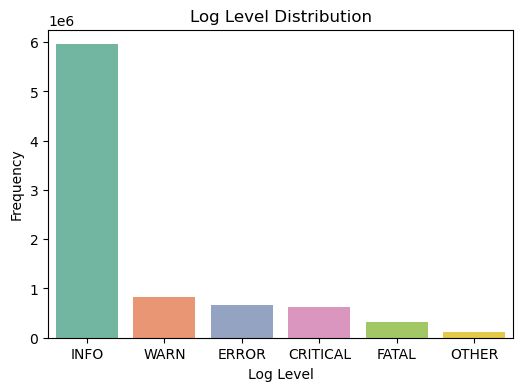

In [20]:
plt.figure(figsize=(6, 4))
sns.countplot(data=logs_df, x='cleaned_level', order=logs_df['cleaned_level'].value_counts().index, palette='Set2')
plt.title('Log Level Distribution')
plt.xlabel('Log Level')
plt.ylabel('Frequency')
plt.show()

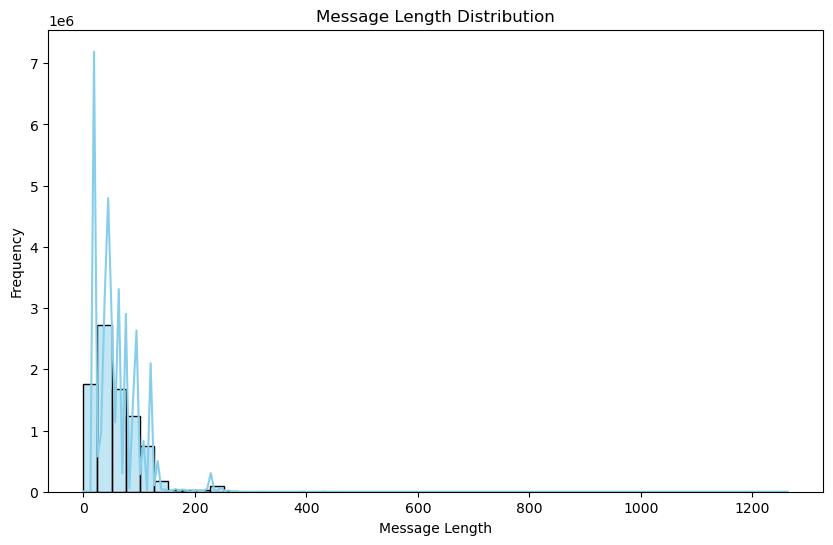

In [21]:
plt.figure(figsize=(10, 6))
sns.histplot(logs_df['message_length'], bins=50, kde=True, color='skyblue')
plt.title('Message Length Distribution')
plt.xlabel('Message Length')
plt.ylabel('Frequency')
plt.show()

Correlation Matrix

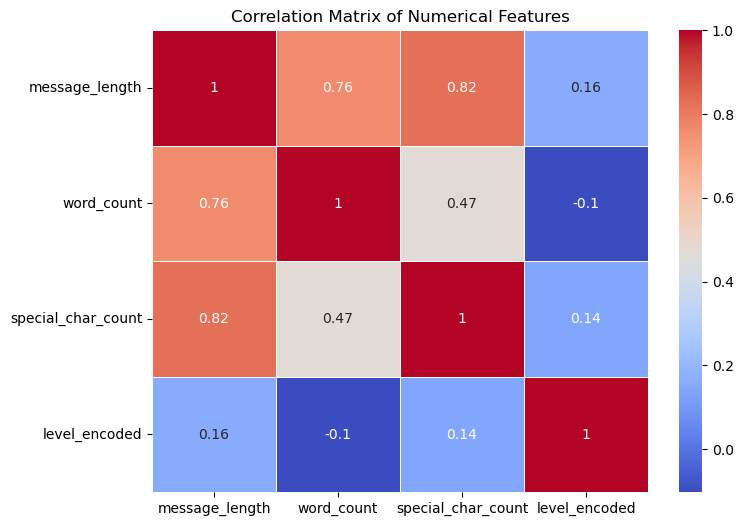

In [22]:
# Select only numeric columns for correlation
numeric_cols = logs_df.select_dtypes(include=['int64', 'float64'])

# Display correlation matrix only for numerical features
plt.figure(figsize=(8, 6))
sns.heatmap(numeric_cols.corr(), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix of Numerical Features')
plt.show()

In [23]:
def refine_level(row):
    if row['cleaned_level'] == 'OTHER':
        if 'error' in row['cleaned_message']: return 'ERROR'
        if 'warning' in row['cleaned_message']: return 'WARN'
        if 'critical' in row['cleaned_message']: return 'CRITICAL'
    return row['cleaned_level']

logs_df['refined_level'] = logs_df.apply(refine_level, axis=1)

In [24]:
logs_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8505002 entries, 0 to 8505001
Data columns (total 12 columns):
 #   Column              Dtype 
---  ------              ----- 
 0   timestamp           object
 1   level               object
 2   message             object
 3   source              object
 4   cleaned_level       object
 5   log_source          object
 6   cleaned_message     object
 7   message_length      int64 
 8   word_count          int64 
 9   special_char_count  int64 
 10  level_encoded       int64 
 11  refined_level       object
dtypes: int64(4), object(8)
memory usage: 778.7+ MB


In [25]:
label_encoder = LabelEncoder()
logs_df["encoded_level"] = label_encoder.fit_transform(logs_df["refined_level"])

In [26]:
# Check mapping of encoded labels
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Label Encoding Mapping:", label_mapping)

Label Encoding Mapping: {'CRITICAL': 0, 'ERROR': 1, 'FATAL': 2, 'INFO': 3, 'OTHER': 4, 'WARN': 5}


In [27]:
logs_df = logs_df.drop(columns=['level_encoded'])  # Keeping `encoded_level`

#### Model Training

Splitting the Dataset

In [28]:
X = logs_df[["message_length", "word_count", "special_char_count"]]
y = logs_df["encoded_level"]

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21, stratify=y)

In [30]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Training the model

In [31]:
def buildModel(model, model_name, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test):
    model.fit(X_train, y_train)
    print(f"Training model: {model_name}")
    y_pred = model.predict(X_test)

    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    print("-----------------------------------------------------------")
    return y_pred

def visualize_confusion_matrix(y_pred_classes):
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred_classes)
    plt.title('Confusion Matrix')
    plt.show()

In [32]:
SGD_Classifier = SGDClassifier()
buildModel(SGD_Classifier, 
           model_name="SGD Classifier", 
           X_train=X_train_scaled,
           X_test=X_test_scaled,
           y_train=y_train,
           y_test=y_test)

Training model: SGD Classifier
[[      0       0       0  102140       0   22790]
 [      0      84     253  110520       0   22478]
 [      0     151   16497   47642       0       4]
 [      0     714    9579 1153417       0   27204]
 [      0    1021     677   16724       0    2324]
 [      0      16       0  120323       0   46443]]


/opt/miniconda3/envs/alertops-ai/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00    124930
           1       0.04      0.00      0.00    133335
           2       0.61      0.26      0.36     64294
           3       0.74      0.97      0.84   1190914
           4       0.00      0.00      0.00     20746
           5       0.38      0.28      0.32    166782

    accuracy                           0.72   1701001
   macro avg       0.30      0.25      0.25   1701001
weighted avg       0.58      0.72      0.63   1701001

-----------------------------------------------------------


/opt/miniconda3/envs/alertops-ai/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/miniconda3/envs/alertops-ai/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


array([3, 3, 3, ..., 3, 3, 3])